In [1]:
# Play Predictability Model (LSTM)

#Predict **pass vs run** and **offensive formation** (ReceiverAlignment) for the next play using:
#- **Game state**: time left in quarter/game, down, yards to go, field position, score differential
#- **Play sequence**: previous plays in the drive (formation, pass/run, down/distance)

#The model outputs **P(pass)** and **P(formation)** for each unique formation per play.

In [2]:
# Install PyTorch in the current kernel (run once if you get ModuleNotFoundError: No module named 'torch')
import sys
!{sys.executable} -m pip install torch --quiet



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [4]:
# Load data and build drive-level sequences
df = pd.read_csv('2026_FAB_play_by_play.csv', low_memory=False)

# Chronological order within each game
df = df.sort_values(['Season', 'Wk', 'HomeTeam', 'AwayTeam', 'QTR', 'TimeLeftQTR'], ascending=[True, True, True, True, True, False])
df['_game_play_seq'] = df.groupby(['Season', 'Wk', 'HomeTeam', 'AwayTeam']).cumcount()

# Drive = new possession (offense changes)
df['_drive_id'] = df.groupby(['Season', 'Wk', 'HomeTeam', 'AwayTeam'], group_keys=False).apply(
    lambda g: (g['OffTeam'] != g['OffTeam'].shift(1)).cumsum(), include_groups=False
)

# Time left in game (seconds): approximate from QTR and TimeLeftQTR
df['TimeLeftGame'] = (4 - df['QTR']) * 900 + df['TimeLeftQTR']  # 900 sec per quarter

# Pass = 1, Rush = 0
df['is_pass'] = (df['EventType'] == 'pass').astype(int)

# Formation (ReceiverAlignment): predict all classes except 'Other' and 'Kneel Down'; class balance in training
FORMATION_MIN_COUNT = 100
formation_counts = df['ReceiverAlignment'].fillna('Other').value_counts()
main_formations = formation_counts[formation_counts >= FORMATION_MIN_COUNT].index.tolist()
FORMATION_LIST = [f for f in main_formations if f not in ('Other', 'Kneel Down')]
formation_to_idx = {f: i for i, f in enumerate(FORMATION_LIST)}
n_formations = len(FORMATION_LIST)

df['formation_clean'] = df['ReceiverAlignment'].fillna('Other').where(
    df['ReceiverAlignment'].fillna('Other').isin(main_formations),
    'Other'
)
df['formation_idx'] = df['formation_clean'].map(formation_to_idx)

# --- Feature engineering for drive-as-sequence LSTM ---
# Cyclical time: 0:05 in Q2 is similar to 0:05 in Q4; sin/cos over game clock
df['TimeSin'] = np.sin(2 * np.pi * df['TimeLeftGame'] / (4 * 900))
df['TimeCos'] = np.cos(2 * np.pi * df['TimeLeftGame'] / (4 * 900))
# Personnel archetype (e.g. 11, 12, 21) for embedding
df['RB'] = df['RB'].fillna(0).astype(int).clip(0, 3)
df['WR'] = df['WR'].fillna(0).astype(int).clip(0, 5)
df['TE'] = df['TE'].fillna(0).astype(int).clip(0, 3)
df['OL'] = df['OL'].fillna(5).astype(int).clip(4, 8)
personnel_str = df['RB'].astype(str) + df['WR'].astype(str) + df['TE'].astype(str)
personnel_vocab = sorted(personnel_str.unique())
personnel_to_idx = {p: i for i, p in enumerate(personnel_vocab)}
df['personnel_idx'] = personnel_str.map(personnel_to_idx).fillna(0).astype(int)
n_personnel = len(personnel_vocab)
# Personnel matchup: WR count vs DB count (indicator for pass tendency)
df['DB'] = df['DB'].fillna(4).astype(int)
df['Personnel_Matchup'] = (df['WR'].astype(float) - df['DB'].astype(float))
# Previous play outcome within drive (lag by 1)
drive_cols = ['Season', 'Wk', 'HomeTeam', 'AwayTeam', '_drive_id']
df['Previous_Play_Type'] = df.groupby(drive_cols)['is_pass'].shift(1).fillna(0.5)
df['Previous_Yards'] = df.groupby(drive_cols)['YardsOnPlay'].shift(1).fillna(0)
df['Previous_EPA'] = df.groupby(drive_cols)['EPA'].shift(1).fillna(0)

# --- Drive DNA (past-context only, for formation prediction) ---
# Rolling Personnel: mean RB/WR/TE over last 3 plays (teams rarely swap mid-drive)
df['Rolling_RB'] = df.groupby(drive_cols)['RB'].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
df['Rolling_WR'] = df.groupby(drive_cols)['WR'].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
df['Rolling_TE'] = df.groupby(drive_cols)['TE'].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
# Success momentum: rolling EPA and Yards (coach tendency to repeat)
df['Rolling_EPA'] = df.groupby(drive_cols)['EPA'].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
df['Rolling_Yards'] = df.groupby(drive_cols)['YardsOnPlay'].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
for c in ['Rolling_RB', 'Rolling_WR', 'Rolling_TE', 'Rolling_EPA', 'Rolling_Yards']:
    df[c] = df[c].fillna(0)
# Hurry-up flag: seconds between previous snap and this one
df['TimeSincePrevPlay'] = df.groupby(drive_cols)['TimeLeftGame'].shift(1) - df['TimeLeftGame']
df['TimeSincePrevPlay'] = df['TimeSincePrevPlay'].clip(lower=0).fillna(0)
# Previous play's coverage (offenses adjust to how defense just played)
df['Prev_CoverageType'] = df.groupby(drive_cols)['CoverageType'].shift(1).fillna('Unknown')
coverage_vocab = sorted(set(df['Prev_CoverageType'].dropna().unique().tolist()) | {'Unknown'})
coverage_to_idx = {c: i for i, c in enumerate(coverage_vocab)}
df['Prev_CoverageType_idx'] = df['Prev_CoverageType'].map(coverage_to_idx).fillna(0).astype(int)
n_coverage = len(coverage_vocab)
# OffTeam as proxy for play-caller (coach/coordinator embedding)
off_team_vocab = sorted(df['OffTeam'].dropna().unique().tolist())
off_team_to_idx = {t: i for i, t in enumerate(off_team_vocab)}
df['off_team_idx'] = df['OffTeam'].map(off_team_to_idx).fillna(0).astype(int)
n_off_teams = len(off_team_vocab)
# Spatial "heatmap": L1..L4, R4..R1 as distance from center (-1 to +1)
ALIGN_COLS = ['L1', 'L2', 'L3', 'L4', 'R4', 'R3', 'R2', 'R1']
align_pos = [-0.25, -0.5, -0.75, -1.0, 1.0, 0.75, 0.5, 0.25]
for c, pos in zip(ALIGN_COLS, align_pos):
    if c in df.columns:
        used = df[c].notna() & (df[c].astype(str).str.upper() != 'NULL')
        df['Align_' + c] = np.where(used, pos, 0.0).astype(np.float32)
    else:
        df['Align_' + c] = 0.0

# --- Trips vs Slot / formation-distinction features ---
# Right_Side_Count: bodies on right (Trips ~3, Slot/Twin ~2)
rwr_ = df['RWR'].fillna(0).astype(float)
rswr_ = df['RSWR'].fillna(0).astype(float)
rte_ = df['RTE'].fillna(0).astype(float)
used_r1 = df['R1'].notna() & (df['R1'].astype(str).str.upper() != 'NULL')
used_r2 = df['R2'].notna() & (df['R2'].astype(str).str.upper() != 'NULL')
used_r3 = df['R3'].notna() & (df['R3'].astype(str).str.upper() != 'NULL')
used_r4 = df['R4'].notna() & (df['R4'].astype(str).str.upper() != 'NULL')
df['Right_Side_Count'] = (rwr_ + rswr_ + rte_ + used_r1.astype(float) + used_r2.astype(float) + used_r3.astype(float) + used_r4.astype(float)).clip(0, 7).astype(np.float32)
# Max_Right_Width: furthest right receiver index (1-4); Trips often wider
df['Max_Right_Width'] = np.where(used_r4, 4, np.where(used_r3, 3, np.where(used_r2, 2, np.where(used_r1, 1, 0)))).astype(np.float32)
# Right_Spread_Index: Max - Min right slot (Trips = wider spread)
min_right = np.where(used_r1, 1, np.where(used_r2, 2, np.where(used_r3, 3, np.where(used_r4, 4, 0))))
df['Right_Spread_Index'] = (df['Max_Right_Width'].astype(int) - min_right).clip(0, 4).astype(np.float32)
# Is_TE_Opposite: strength right and TE left => Trips signature
lwr_ = df['LWR'].fillna(0).astype(float)
lswr_ = df['LSWR'].fillna(0).astype(float)
lte_ = df['LTE'].fillna(0).astype(float)
used_l1 = df['L1'].notna() & (df['L1'].astype(str).str.upper() != 'NULL')
used_l2 = df['L2'].notna() & (df['L2'].astype(str).str.upper() != 'NULL')
used_l3 = df['L3'].notna() & (df['L3'].astype(str).str.upper() != 'NULL')
used_l4 = df['L4'].notna() & (df['L4'].astype(str).str.upper() != 'NULL')
left_count = lwr_ + lswr_ + lte_ + used_l1.astype(float) + used_l2.astype(float) + used_l3.astype(float) + used_l4.astype(float)
right_count = rwr_ + rswr_ + rte_ + used_r1.astype(float) + used_r2.astype(float) + used_r3.astype(float) + used_r4.astype(float)
df['Is_TE_Opposite'] = ((right_count > left_count) & (df['LTE'].fillna(0).astype(float) >= 1)).astype(np.float32)
# Personnel_x_StrengthCount: 10 personnel (1 RB, 0 TE) + 3 right => Trips
is_10_personnel = (df['RB'] == 1) & (df['TE'] == 0)
df['Personnel_x_StrengthCount'] = (df['Right_Side_Count'] * np.where(is_10_personnel, 1.0, 0.0)).astype(np.float32)

# --- Holistic Formation Family & Symmetry (replace L1-R4 coordinate-based for model input) ---
df['Total_Left_Count'] = left_count.clip(0, 7).astype(np.float32)
df['Total_Right_Count'] = right_count.clip(0, 7).astype(np.float32)
df['Symmetry_Delta'] = (df['Total_Left_Count'] - df['Total_Right_Count']).astype(np.float32)
# Formation Family: spatial distribution (Spread / Condensed_Nasty / Bunch_Stack / Empty / Other)
align_cols_abs = ['Align_L1', 'Align_L2', 'Align_L3', 'Align_L4', 'Align_R4', 'Align_R3', 'Align_R2', 'Align_R1']
used_align = df[align_cols_abs].abs() > 1e-6
n_used = used_align.sum(axis=1).replace(0, 1)
avg_dist_center = (df[align_cols_abs].abs() * used_align.astype(float)).sum(axis=1) / n_used
is_spread = (avg_dist_center > 0.6).values
inner_only = ~(used_l3 | used_l4 | used_r3 | used_r4).values
bunch_left = (used_l1 & used_l2) | (used_l2 & used_l3) | (used_l3 & used_l4)
bunch_right = (used_r1 & used_r2) | (used_r2 & used_r3) | (used_r3 & used_r4)
is_bunch_stack = (bunch_left | bunch_right).values
total_receivers = (df['Total_Left_Count'] + df['Total_Right_Count']).values
is_empty = (df['RB'].fillna(0).values == 0) & (total_receivers >= 5)
no_receivers = (total_receivers == 0)
family = np.where(no_receivers, 'Other', np.where(is_empty, 'Empty', np.where(is_spread, 'Spread', np.where(inner_only, 'Condensed_Nasty', np.where(is_bunch_stack, 'Bunch_Stack', 'Other')))))
df['Formation_Family'] = family
formation_family_vocab = ['Spread', 'Condensed_Nasty', 'Bunch_Stack', 'Empty', 'Other']
formation_family_to_idx = {f: i for i, f in enumerate(formation_family_vocab)}
df['Formation_Family_idx'] = df['Formation_Family'].map(formation_family_to_idx).fillna(4).astype(int)

# --- Drive-aware lagging: all holistic features lagged by 1 (groupby = drive) ---
df['Prev_Symmetry_Delta'] = df.groupby(drive_cols)['Symmetry_Delta'].shift(1)
df['Prev_Formation_Family_idx'] = df.groupby(drive_cols)['Formation_Family_idx'].shift(1)
# Symmetry_Volatility: std of Symmetry_Delta over last 3 plays (of lagged series)
df['Symmetry_Volatility'] = df.groupby(drive_cols)['Prev_Symmetry_Delta'].transform(lambda x: x.rolling(3, min_periods=1).std())
# Spread_Rate: % of last 4 plays that were Spread (lagged then rolling mean)
df['_was_Spread'] = (df['Formation_Family'] == 'Spread').astype(float)
df['_Prev_was_Spread'] = df.groupby(drive_cols)['_was_Spread'].shift(1)
df['Spread_Rate'] = df.groupby(drive_cols)['_Prev_was_Spread'].transform(lambda x: x.rolling(4, min_periods=1).mean())
df.drop(columns=['_was_Spread', '_Prev_was_Spread'], inplace=True)
# Formation + success: e.g. Trips_Right_Success = 1 if last play was Trips Right and had positive EPA
df['_Prev_Formation'] = df.groupby(drive_cols)['formation_clean'].shift(1)
for f in FORMATION_LIST:
    col = f.replace(' ', '_') + '_Success'
    df[col] = ((df['_Prev_Formation'] == f) & (df['Previous_EPA'] > 0)).astype(np.float32)
df.drop(columns=['_Prev_Formation'], inplace=True)
# Keep legacy lagged/rolling for optional use; fill first-play NaNs with 0
df['Prev_Right_Side_Count'] = df.groupby(drive_cols)['Right_Side_Count'].shift(1)
df['Prev_Max_Right_Width'] = df.groupby(drive_cols)['Max_Right_Width'].shift(1)
df['Prev_Right_Spread_Index'] = df.groupby(drive_cols)['Right_Spread_Index'].shift(1)
df['Prev_Is_TE_Opposite'] = df.groupby(drive_cols)['Is_TE_Opposite'].shift(1)
df['Prev_Personnel_x_StrengthCount'] = df.groupby(drive_cols)['Personnel_x_StrengthCount'].shift(1)
df['Rolling_3_Right_Side_Count'] = df.groupby(drive_cols)['Prev_Right_Side_Count'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df['Rolling_3_Max_Right_Width'] = df.groupby(drive_cols)['Prev_Max_Right_Width'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df['Rolling_3_Right_Spread_Index'] = df.groupby(drive_cols)['Prev_Right_Spread_Index'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df['Rolling_3_Is_TE_Opposite'] = df.groupby(drive_cols)['Prev_Is_TE_Opposite'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df['Rolling_3_Personnel_x_StrengthCount'] = df.groupby(drive_cols)['Prev_Personnel_x_StrengthCount'].transform(lambda x: x.rolling(3, min_periods=1).mean())
holistic_lag_cols = ['Prev_Symmetry_Delta', 'Prev_Formation_Family_idx', 'Symmetry_Volatility', 'Spread_Rate',
    'Prev_Right_Side_Count', 'Prev_Max_Right_Width', 'Prev_Right_Spread_Index', 'Prev_Is_TE_Opposite', 'Prev_Personnel_x_StrengthCount',
    'Rolling_3_Right_Side_Count', 'Rolling_3_Max_Right_Width', 'Rolling_3_Right_Spread_Index', 'Rolling_3_Is_TE_Opposite', 'Rolling_3_Personnel_x_StrengthCount']
for c in holistic_lag_cols:
    df[c] = df[c].fillna(0).astype(np.float32)

# Verification: first play of each drive has lagged/rolling holistic = 0 (no prior-play info)
first_play_mask = df.groupby(drive_cols).cumcount() == 0
assert (df.loc[first_play_mask, 'Prev_Symmetry_Delta'] == 0).all(), 'First play of drive should have Prev_Symmetry_Delta = 0'
assert (df.loc[first_play_mask, 'Symmetry_Volatility'] == 0).all(), 'First play of drive should have Symmetry_Volatility = 0'
assert (df.loc[first_play_mask, 'Spread_Rate'] == 0).all(), 'First play of drive should have Spread_Rate = 0'
print('Verification: first play of drive has lagged/rolling holistic formation features = 0 (no leakage).')

# Only train/predict on plays with a non-Other ReceiverAlignment (after all features exist)
df_model = df[df['formation_clean'].isin(FORMATION_LIST)].copy()
df_model['formation_idx'] = df_model['formation_clean'].map(formation_to_idx).astype(int)

print('Receiver alignment classes we predict (excl. Other, Kneel Down):', FORMATION_LIST)
print('n_formations:', n_formations, '| n_personnel:', n_personnel, '| n_coverage:', n_coverage, '| n_off_teams:', n_off_teams)
print('Total plays (full df):', len(df), '| Plays used for model:', len(df_model))

Verification: first play of drive has lagged/rolling holistic formation features = 0 (no leakage).
Receiver alignment classes we predict (excl. Other, Kneel Down): ['Balanced', 'Slot Left', 'Twin Right', 'Twin Left', 'Trips Right', 'Slot Right', 'Trips Left', 'Single Left', 'Single Right', 'Spread', 'Bunch Right', 'Bunch Left', 'All Tight', 'Goal Line']
n_formations: 14 | n_personnel: 34 | n_coverage: 15 | n_off_teams: 32
Total plays (full df): 33326 | Plays used for model: 32766


In [5]:
pd.set_option('display.max_columns', None)
df

,Season,Wk,HomeTeam,AwayTeam,QTR,TimeLeftQTR,OffTeam,DefTeam,OffLeadBefore,FieldSide,StartYard,Down,ToGo,EventType,RB,WR,TE,OL,DL,LB,DB,Safeties,CoverageType,ReceiverAlignment,Dropback,DropType,Scramble,RPO,Attempt,Completion,Sacked,LWR,LSWR,LTE,RWR,RSWR,RTE,L1,L2,L3,L4,R4,R3,R2,R1,TargetedPlayer,YardsOnPlay,EPA,_game_play_seq,_drive_id,TimeLeftGame,is_pass,formation_clean,formation_idx,TimeSin,TimeCos,personnel_idx,Personnel_Matchup,Previous_Play_Type,Previous_Yards,Previous_EPA,Rolling_RB,Rolling_WR,Rolling_TE,Rolling_EPA,Rolling_Yards,TimeSincePrevPlay,Prev_CoverageType,Prev_CoverageType_idx,off_team_idx,Align_L1,Align_L2,Align_L3,Align_L4,Align_R4,Align_R3,Align_R2,Align_R1,Right_Side_Count,Max_Right_Width,Right_Spread_Index,Is_TE_Opposite,Personnel_x_StrengthCount,Total_Left_Count,Total_Right_Count,Symmetry_Delta,Formation_Family,Formation_Family_idx,Prev_Symmetry_Delta,Prev_Formation_Family_idx,Symmetry_Volatility,Spread_Rate,Balanced_Success,Slot_Left_Success,Twin_Right_Success,Twin_Left_Success,Trips_Right_Success,Slot_Right_Success,Trips_Left_Success,Single_Left_Success,Single_Right_Success,Spread_Success,Bunch_Right_Success,Bunch_Left_Success,All_Tight_Success,Goal_Line_Success,Prev_Right_Side_Count,Prev_Max_Right_Width,Prev_Right_Spread_Index,Prev_Is_TE_Opposite,Prev_Personnel_x_StrengthCount,Rolling_3_Right_Side_Count,Rolling_3_Max_Right_Width,Rolling_3_Right_Spread_Index,Rolling_3_Is_TE_Opposite,Rolling_3_Personnel_x_StrengthCount
0,2025,1,ATL,TB,1,894,ATL,TB,0,Own,35,1,10,pass,2,2,1,5,3.0,4.0,4,2,Cover 2,Spread,1.0,0/1 Step,0,0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,Hook,Cross,Out,NaN,NaN,NaN,Shallow,Cross,R1,11,0.529828,0,1,3594,1,Spread,9.0,-0.010472,0.999945,28,-2.0,0.5,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,Unknown,14,1,-0.25,-0.5,-0.75,0.0,0.0,0.00,0.5,0.25,4.0,2.0,1.0,0.0,0.0,6.0,4.0,2.0,Bunch_Stack,2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,2025,1,ATL,TB,1,850,ATL,TB,0,Own,46,1,10,rush,1,2,2,5,3.0,4.0,4,1,NaN,Slot Left,NaN,NaN,0,0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,-0.235060,1,1,3550,0,Slot Left,1.0,-0.087156,0.996195,15,-2.0,1.0,11.0,0.529828,2.0,2.000000,1.000000,0.529828,11.000000,44.0,Cover 2,3,1,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,2.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,Condensed_Nasty,1,2.0,2.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,2.0,1.0,0.0,0.0,4.000000,2.000000,1.0,0.0,0.0
2,2025,1,ATL,TB,1,806,ATL,TB,0,Own,50,2,6,pass,1,2,2,5,3.0,4.0,4,1,Cover 6,Twin Right,1.0,5 Step,0,0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,Cross,NaN,NaN,NaN,NaN,NaN,Post,Corner,Back,50,3.796560,2,1,3506,1,Twin Right,2.0,-0.163326,0.986572,15,-2.0,0.0,4.0,-0.235060,1.5,2.000000,1.500000,0.147384,7.500000,44.0,Unknown,14,1,-0.25,0.0,0.00,0.0,0.0,0.00,0.5,0.25,4.0,2.0,1.0,1.0,0.0,3.0,4.0,-1.0,Condensed_Nasty,1,0.0,1.0,1.414214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.000000,1.000000,0.5,0.0,0.0
3,2025,1,ATL,TB,1,794,TB,ATL,-7,Own,40,1,10,pass,1,2,2,5,4.0,2.0,5,1,Cover 1,Balanced,1.0,3 Step,0,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,Cross,NaN,NaN,NaN,NaN,NaN,Flat,Corner,NaN,0,-0.687909,3,2,3494,1,Balanced,0.0,-0.183951,0.982935,15,-3.0,0.5,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,Unknown,14,29,-0.25,0.0,0.00,0.0,0.0,0.00,0.5,0.25,4.0,2.0,1.0,1.0,0.0,3.0,4.0,-1.0,Condensed_Nasty,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,2025,1,ATL,TB,1,789,TB,ATL,-7,Own,40,2,10,rush,2,2,1,5,3.0,4.0,4,1,NaN,Trips Left,NaN,NaN,0,1,NaN,NaN,NaN,1.0,2.0,0.0,0.0,0.0,1.0,NaN,NaN,Screen,NaN,NaN,NaN,NaN,NaN,NaN,2,-0.693373,4,2,3489,0,Trips Left,6.0,-0.192522,0.981293,28,-2.0,1.0,0.0,-0.687909,1.0,2.000000,2.000000,-0.687909,0.000000,5.0,Cover 1,2,29,0.00,0.0,-0.75,0.0,0.0,0.00,0.0,0.00,1.0,0.0,0.0,0.0,0.0,4.0,1.0,3.0,Spread,0,-1.0,1.0,0.000000,0.0,0.0,0.

In [6]:
# Sequence = past plays only; game state (Down/ToGo/etc.) is current-play only
SEQ_LEN = 8
# Data sanitization: L1-L4, R1-R4, LWR, RWR, LSWR, RSWR and ReceiverAlignment are EXCLUDED from X.
# Game state: current play only (not in sequence or drive context)
CURRENT_GAME_STATE = ['Down', 'ToGo', 'TimeSin', 'TimeCos', 'OffLeadBefore', 'StartYard']
SEQ_PERSONNEL = ['RB', 'WR', 'TE', 'OL']  # previous play's design (not current play)
SEQ_OUTCOME = ['Previous_Play_Type', 'Previous_Yards', 'Previous_EPA']
SEQ_EXTRA = ['Personnel_Matchup']
HOLISTIC_SEQ = ['Symmetry_Delta', 'Formation_Family_idx']
seq_feat_cols = SEQ_PERSONNEL + SEQ_OUTCOME + SEQ_EXTRA + HOLISTIC_SEQ  # no Down/ToGo/etc. in sequence
# Drive context for TARGET play: only lagged/rolling (no current-play alignment or personnel)
HOLISTIC_DRIVE = ['Prev_Symmetry_Delta', 'Prev_Formation_Family_idx', 'Symmetry_Volatility', 'Spread_Rate']
FORMATION_SUCCESS_FEAT = [f.replace(' ', '_') + '_Success' for f in FORMATION_LIST]
DRIVE_CONTEXT_FEAT = ['Rolling_EPA', 'Rolling_Yards', 'Rolling_RB', 'Rolling_WR', 'Rolling_TE', 'TimeSincePrevPlay', 'Prev_CoverageType_idx'] + HOLISTIC_DRIVE + FORMATION_SUCCESS_FEAT

def build_sequence_rows(data, seq_len=SEQ_LEN):
    rows = []
    for _, drive in data.groupby(['Season', 'Wk', 'HomeTeam', 'AwayTeam', '_drive_id']):
        drive = drive.sort_values('_game_play_seq')
        for i in range(len(drive)):
            row = drive.iloc[i]
            n_prev = min(i, seq_len)
            if n_prev > 0:
                prev_plays = drive.iloc[i - n_prev:i]
                seq_part = prev_plays[seq_feat_cols].values.astype(np.float32)
                seq = np.zeros((seq_len, len(seq_feat_cols)), dtype=np.float32)
                seq[seq_len - n_prev:] = seq_part
            else:
                seq = np.zeros((seq_len, len(seq_feat_cols)), dtype=np.float32)
            drive_context = row[DRIVE_CONTEXT_FEAT].values.astype(np.float32)
            current_game_state = row[CURRENT_GAME_STATE].values.astype(np.float32)
            rows.append({
                'seq': seq,
                'drive_context': drive_context,
                'current_game_state': current_game_state,
                'off_team_idx': int(row['off_team_idx']),
                'is_pass': row['is_pass'],
                'formation_idx': row['formation_idx'],
                'df_index': drive.index[i],
            })
    return rows

rows = build_sequence_rows(df_model, SEQ_LEN)
SEQ_INPUT_DIM = len(seq_feat_cols)
DRIVE_CONTEXT_DIM = len(DRIVE_CONTEXT_FEAT)
CURRENT_GAME_STATE_DIM = len(CURRENT_GAME_STATE)
print('Sequence length:', SEQ_LEN, '| Seq dim:', SEQ_INPUT_DIM, '| Drive context dim:', DRIVE_CONTEXT_DIM, '| Game state dim:', CURRENT_GAME_STATE_DIM)
print('Number of plays:', len(rows))

def scale_seq_and_current(seq, drive_context, current_game_state):
    seq = seq.copy()
    dc = drive_context.copy()
    gs = current_game_state.copy()
    # Seq (10): 0-3 RB/WR/TE/OL, 4-6 outcome, 7 Personnel_Matchup, 8-9 holistic
    seq[:, 0] = np.clip(seq[:, 0], 0, 3) / 3.0
    seq[:, 1] = np.clip(seq[:, 1], 0, 5) / 5.0
    seq[:, 2] = np.clip(seq[:, 2], 0, 3) / 3.0
    seq[:, 3] = np.clip(seq[:, 3], 4, 8) / 8.0
    seq[:, 4] = np.clip(seq[:, 4], 0, 1)
    seq[:, 5] = np.clip(seq[:, 5], -20, 50) / 50.0
    seq[:, 6] = np.clip(seq[:, 6], -15, 15) / 15.0
    seq[:, 7] = np.clip(seq[:, 7], -5, 5) / 5.0
    seq[:, 8] = np.clip(seq[:, 8], -7, 7) / 7.0
    seq[:, 9] = np.clip(seq[:, 9], 0, 4) / 4.0
    # Current game state (the play we're predicting): Down, ToGo, TimeSin, TimeCos, OffLeadBefore, StartYard
    gs[0] = (gs[0] - 1) / 3.0
    gs[1] = (gs[1] - 1) / 18.0
    gs[2] = np.clip(gs[2], -1, 1)
    gs[3] = np.clip(gs[3], -1, 1)
    gs[4] = np.clip(gs[4], -40, 40) / 80.0
    gs[5] = np.clip(gs[5], 0, 100) / 100.0
    # Drive context
    dc[0] = np.clip(dc[0], -15, 15) / 15.0
    dc[1] = np.clip(dc[1], -20, 50) / 50.0
    dc[5] = np.clip(dc[5], 0, 120) / 120.0
    dc[6] = dc[6] / max(n_coverage - 1, 1)
    dc[7] = np.clip(dc[7], -7, 7) / 7.0
    dc[8] = np.clip(dc[8], 0, 4) / 4.0
    dc[9] = np.clip(dc[9], 0, 5) / 5.0
    dc[10] = np.clip(dc[10], 0, 1)
    for i in range(11, len(dc)):
        dc[i] = np.clip(dc[i], 0, 1)
    return seq, dc, gs

Sequence length: 8 | Seq dim: 10 | Drive context dim: 25 | Game state dim: 6
Number of plays: 32766


## Model feature reference

The model uses **three input blocks** (no current-play alignment or raw L1–R4/LWR/RSWR).  
Shape: **sequence** `(samples, 8, 10)` + **drive context** `(samples, 11 + n_formations)` + **current game state** `(samples, 6)`.

---

### 1. Sequence features (per timestep = one past play)

Each of the 8 timesteps is one **previous** play in the drive. All 16 features below are from **that** play (no leakage from the current play).

| # | Feature | Description |
|---|---------|-------------|
| 0 | **RB** | Running backs on that play (previous play’s design). |
| 1 | **WR** | Wide receivers on that play. |
| 2 | **TE** | Tight ends on that play. |
| 3 | **OL** | Offensive linemen on that play. |
| 4 | **Previous_Play_Type** | 1 = pass, 0 = rush (for the play *before* that timestep). |
| 5 | **Previous_Yards** | Yards gained on the previous play. |
| 6 | **Previous_EPA** | EPA of the previous play. |
| 7 | **Personnel_Matchup** | WR count − DB count on that play. |
| 8 | **Symmetry_Delta** | Total_Left_Count − Total_Right_Count for that play (holistic alignment). |
| 9 | **Formation_Family_idx** | Formation family for that play: 0=Spread, 1=Condensed_Nasty, 2=Bunch_Stack, 3=Empty, 4=Other. |

**Excluded from the sequence (no leakage):** L1–L4, R1–R4, LWR, RWR, LSWR, RSWR, ReceiverAlignment.

---

### 2. Drive context features (for the **target** play only)

Single vector per sample; all values are **lagged or rolling** (no current-play alignment or personnel).

| # | Feature | Description |
|---|---------|-------------|
| 0 | **Rolling_EPA** | Mean EPA over the last 3 plays (before current), within drive. |
| 1 | **Rolling_Yards** | Mean yards over the last 3 plays. |
| 2 | **Rolling_RB** | Mean RB count over the last 3 plays (lagged). |
| 3 | **Rolling_WR** | Mean WR count over the last 3 plays. |
| 4 | **Rolling_TE** | Mean TE count over the last 3 plays. |
| 5 | **TimeSincePrevPlay** | Seconds since the previous snap (clipped ≥ 0). |
| 6 | **Prev_CoverageType_idx** | Coverage type of the **previous** play (encoded). |
| 7 | **Prev_Symmetry_Delta** | Symmetry_Delta of the **previous** play (lagged by 1). |
| 8 | **Prev_Formation_Family_idx** | Formation_Family_idx of the **previous** play (lagged by 1). |
| 9 | **Symmetry_Volatility** | Std of Symmetry_Delta over the last 3 plays (of the lagged series). |
| 10 | **Spread_Rate** | Fraction of the last 4 plays that were Formation_Family = Spread (lagged then rolling). |
| 11+ | **{Formation}_Success** | One binary per formation (e.g. **Trips_Right_Success**): 1 if the **previous** play used that formation and had positive EPA, 0 otherwise. Coaches tend to return to “winning” looks. |

On the **first play of a drive**, lagged/rolling holistic features (e.g. Prev_Symmetry_Delta, Symmetry_Volatility, Spread_Rate) and all formation-success binaries are 0 so the model sees no prior alignment.

---

### 3. Current game state (the play we're predicting)

Taken at face value for the **current** play only (not in sequence or drive context).

| # | Feature | Description |
|---|---------|-------------|
| 0 | **Down** | Down (1–4). |
| 1 | **ToGo** | Yards to go (1–19). |
| 2 | **TimeSin** | Sin of game clock (cyclical time). |
| 3 | **TimeCos** | Cos of game clock. |
| 4 | **OffLeadBefore** | Score differential (offense minus defense) before the play. |
| 5 | **StartYard** | Field position (0–100). |

---

### 4. Targets (not inputs)

- **Pass vs run:** binary from `EventType` (pass=1, rush=0).  
- **Formation:** `ReceiverAlignment` mapped to `formation_idx` (all formations except Other and Kneel Down).

In [7]:
class PredictabilityLSTM(nn.Module):
    """Past-context only: 8-play sequence + drive DNA + OffTeam (play-caller) embedding; LayerNorm; Focal-ready."""

    def __init__(self, seq_input_size=SEQ_INPUT_DIM, drive_context_size=DRIVE_CONTEXT_DIM, current_game_state_size=CURRENT_GAME_STATE_DIM,
                 n_off_teams=n_off_teams, embed_dim=8, hidden_size=64, n_formations=n_formations, dropout=0.3):
        super().__init__()
        self.n_formations = n_formations
        self.off_team_embed = nn.Embedding(n_off_teams, embed_dim)
        self.layer_norm = nn.LayerNorm(seq_input_size)
        self.lstm = nn.LSTM(seq_input_size, hidden_size, batch_first=True, dropout=dropout)
        combined_size = hidden_size + drive_context_size + current_game_state_size + embed_dim
        self.fc = nn.Sequential(
            nn.Linear(combined_size, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.pass_head = nn.Linear(64, 1)
        self.formation_head = nn.Linear(64, n_formations)
        self.log_var_pass = nn.Parameter(torch.zeros(1))
        self.log_var_form = nn.Parameter(torch.zeros(1))

    def forward(self, seq, drive_context, current_game_state, off_team_idx):
        seq = self.layer_norm(seq)
        team_emb = self.off_team_embed(off_team_idx)
        _, (h_n, _) = self.lstm(seq)
        lstm_out = h_n[-1]
        combined = torch.cat([lstm_out, drive_context, current_game_state, team_emb], dim=1)
        x = self.fc(combined)
        pass_logits = self.pass_head(x).squeeze(-1)
        formation_logits = self.formation_head(x)
        return pass_logits, formation_logits

model = PredictabilityLSTM().to(DEVICE)
print(model)
print('Total parameters:', sum(p.numel() for p in model.parameters()))

PredictabilityLSTM(
  (off_team_embed): Embedding(32, 8)
  (layer_norm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (lstm): LSTM(10, 64, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Linear(in_features=103, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (pass_head): Linear(in_features=64, out_features=1, bias=True)
  (formation_head): Linear(in_features=64, out_features=14, bias=True)
)
Total parameters: 27493


In [8]:
class PlaySequenceDataset(Dataset):
    def __init__(self, rows, scale_fn=scale_seq_and_current):
        self.rows = rows
        self.scale_fn = scale_fn

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, i):
        r = self.rows[i]
        seq, drive_context, current_game_state = self.scale_fn(r['seq'], r['drive_context'], r['current_game_state'])
        return (
            torch.from_numpy(seq).float(),
            torch.from_numpy(drive_context).float(),
            torch.from_numpy(current_game_state).float(),
            torch.tensor(r['off_team_idx'], dtype=torch.long),
            torch.tensor(r['is_pass'], dtype=torch.float32),
            torch.tensor(r['formation_idx'], dtype=torch.long)
        )

# Train/val split stratified by ReceiverAlignment (formation)
indices = np.arange(len(rows))
formation_labels = np.array([r['formation_idx'] for r in rows])
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=formation_labels)
train_rows = [rows[i] for i in train_idx]
val_rows = [rows[i] for i in val_idx]

# Undersample 'Balanced' by 60% during training to represent classes more evenly
if 'Balanced' in FORMATION_LIST:
    balanced_idx = FORMATION_LIST.index('Balanced')
    balanced_train_indices = [i for i in range(len(train_rows)) if train_rows[i]['formation_idx'] == balanced_idx]
    n_keep = int(0.4 * len(balanced_train_indices))
    rng = np.random.RandomState(42)
    keep_balanced = set(rng.choice(balanced_train_indices, size=n_keep, replace=False))
    train_rows = [train_rows[i] for i in range(len(train_rows)) if train_rows[i]['formation_idx'] != balanced_idx or i in keep_balanced]
    print('Undersampled Balanced: kept 40% (removed 60%). Train samples after filter:', len(train_rows))

train_ds = PlaySequenceDataset(train_rows)
val_ds = PlaySequenceDataset(val_rows)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
print('Train samples:', len(train_ds), 'Val samples:', len(val_ds))

Undersampled Balanced: kept 40% (removed 60%). Train samples after filter: 21610
Train samples: 21610 Val samples: 6554


In [9]:
# Training: MTL with uncertainty weighting (auto balance pass vs formation loss)
criterion_pass = nn.BCEWithLogitsLoss()
# Focal Loss for formation (focus on hard/rare classes); gamma=2, alpha from class weights
def focal_loss(logits, targets, weight=None, gamma=2.0):
    ce = nn.functional.cross_entropy(logits, targets, weight=weight, reduction='none')
    pt = torch.exp(-ce)
    return ((1 - pt) ** gamma * ce).mean()
criterion_formation = lambda logits, y: focal_loss(logits, y, weight=None, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

def train_epoch(loader):
    model.train()
    total_loss = 0
    for seq, drive_context, current_game_state, off_team_idx, y_pass, y_form in loader:
        seq = seq.to(DEVICE)
        drive_context = drive_context.to(DEVICE)
        current_game_state = current_game_state.to(DEVICE)
        off_team_idx = off_team_idx.to(DEVICE)
        y_pass, y_form = y_pass.to(DEVICE), y_form.to(DEVICE)
        optimizer.zero_grad()
        pass_logits, form_logits = model(seq, drive_context, current_game_state, off_team_idx)
        loss_pass = criterion_pass(pass_logits, y_pass)
        loss_form = criterion_formation(form_logits, y_form)
        # Uncertainty weighting: (1/(2*sigma^2))*L + log(sigma)
        log_vp, log_vf = model.log_var_pass, model.log_var_form
        loss = 0.5 * torch.exp(-log_vp) * loss_pass + 0.5 * log_vp + 0.5 * torch.exp(-log_vf) * loss_form + 0.5 * log_vf
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss = 0
    pass_correct = form_correct = total_n = 0
    for seq, drive_context, current_game_state, off_team_idx, y_pass, y_form in loader:
        seq, drive_context = seq.to(DEVICE), drive_context.to(DEVICE)
        current_game_state = current_game_state.to(DEVICE)
        off_team_idx = off_team_idx.to(DEVICE)
        y_pass, y_form = y_pass.to(DEVICE), y_form.to(DEVICE)
        pass_logits, form_logits = model(seq, drive_context, current_game_state, off_team_idx)
        loss = criterion_pass(pass_logits, y_pass) + criterion_formation(form_logits, y_form)
        total_loss += loss.item()
        pass_correct += ((pass_logits > 0).float() == y_pass).sum().item()
        form_correct += (form_logits.argmax(1) == y_form).sum().item()
        total_n += seq.size(0)
    return total_loss / len(loader), pass_correct / total_n, form_correct / total_n

n_epochs = 12
best_val_loss = float('inf')
for epoch in range(n_epochs):
    train_loss = train_epoch(train_loader)
    val_loss, val_pass_acc, val_form_acc = evaluate(val_loader)
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'config': {
                'SEQ_LEN': SEQ_LEN,
                'SEQ_INPUT_DIM': SEQ_INPUT_DIM,
                'DRIVE_CONTEXT_DIM': DRIVE_CONTEXT_DIM,
                'CURRENT_GAME_STATE_DIM': CURRENT_GAME_STATE_DIM,
                'n_formations': n_formations,
                'n_off_teams': n_off_teams,
                'n_coverage': n_coverage,
            },
            'seq_feat_cols': seq_feat_cols,
            'DRIVE_CONTEXT_FEAT': DRIVE_CONTEXT_FEAT,
            'CURRENT_GAME_STATE': CURRENT_GAME_STATE,
            'FORMATION_LIST': FORMATION_LIST,
            'formation_to_idx': formation_to_idx,
            'off_team_to_idx': off_team_to_idx,
            'coverage_to_idx': coverage_to_idx,
            'formation_family_to_idx': formation_family_to_idx,
        }
        torch.save(checkpoint, 'predictability_lstm.pt')
    print(f"Epoch {epoch+1}/{n_epochs}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  val_pass_acc={val_pass_acc:.4f}  val_form_acc={val_form_acc:.4f}")

Epoch 1/12  train_loss=1.3229  val_loss=2.5345  val_pass_acc=0.6128  val_form_acc=0.2637
Epoch 2/12  train_loss=1.1940  val_loss=2.4572  val_pass_acc=0.6376  val_form_acc=0.2486
Epoch 3/12  train_loss=1.1310  val_loss=2.4469  val_pass_acc=0.6430  val_form_acc=0.2240
Epoch 4/12  train_loss=1.0984  val_loss=2.4164  val_pass_acc=0.6465  val_form_acc=0.2368
Epoch 5/12  train_loss=1.0830  val_loss=2.4076  val_pass_acc=0.6555  val_form_acc=0.2199
Epoch 6/12  train_loss=1.0706  val_loss=2.3849  val_pass_acc=0.6602  val_form_acc=0.2458
Epoch 7/12  train_loss=1.0598  val_loss=2.3830  val_pass_acc=0.6601  val_form_acc=0.2357
Epoch 8/12  train_loss=1.0561  val_loss=2.3683  val_pass_acc=0.6654  val_form_acc=0.2399
Epoch 9/12  train_loss=1.0495  val_loss=2.3884  val_pass_acc=0.6680  val_form_acc=0.2202
Epoch 10/12  train_loss=1.0474  val_loss=2.3724  val_pass_acc=0.6710  val_form_acc=0.2261
Epoch 11/12  train_loss=1.0449  val_loss=2.3551  val_pass_acc=0.6660  val_form_acc=0.2556
Epoch 12/12  train_

In [10]:
# Load best model and compute metrics on validation set
ckpt = torch.load('predictability_lstm.pt', map_location=DEVICE)
if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
    model.load_state_dict(ckpt['model_state_dict'])
    # Optionally restore config/feature lists for inference in another session:
    # SEQ_LEN, seq_feat_cols, DRIVE_CONTEXT_FEAT, CURRENT_GAME_STATE = ckpt['config'], ckpt['seq_feat_cols'], ckpt['DRIVE_CONTEXT_FEAT'], ckpt['CURRENT_GAME_STATE']
    # FORMATION_LIST, formation_to_idx = ckpt['FORMATION_LIST'], ckpt['formation_to_idx']
else:
    model.load_state_dict(ckpt)
model.eval()

val_loss, val_pass_acc, val_form_acc = evaluate(val_loader)
print('Best model — Val pass accuracy: {:.4f}  Val formation accuracy: {:.4f}'.format(val_pass_acc, val_form_acc))

Best model — Val pass accuracy: 0.6704  Val formation accuracy: 0.2501


In [11]:
# Inference: for each play, return P(pass) and P(formation) for every formation
@torch.no_grad()
def predict_proba(loader, model, device):
    """Returns pass_proba (N,) and formation_proba (N, n_formations)."""
    model.eval()
    pass_probs, form_probs = [], []
    for seq, drive_context, current_game_state, off_team_idx, _, _ in loader:
        seq, drive_context = seq.to(device), drive_context.to(device)
        current_game_state = current_game_state.to(device)
        off_team_idx = off_team_idx.to(device)
        pass_logits, form_logits = model(seq, drive_context, current_game_state, off_team_idx)
        pass_probs.append(torch.sigmoid(pass_logits).cpu().numpy())
        form_probs.append(torch.softmax(form_logits, dim=1).cpu().numpy())
    return np.concatenate(pass_probs), np.concatenate(form_probs)

# Run on validation set as example
val_loader_full = DataLoader(val_ds, batch_size=256, shuffle=False)
pass_proba, formation_proba = predict_proba(val_loader_full, model, DEVICE)

print('Shape of P(pass) per play:', pass_proba.shape)
print('Shape of P(formation) per play (one prob per formation):', formation_proba.shape)
print('Formation labels:', FORMATION_LIST)

# Example: first 3 plays — P(pass) and top-3 formations
for i in range(min(3, len(pass_proba))):
    top3_idx = np.argsort(formation_proba[i])[-5:][::-1]
    print('Play {}: P(pass)={:.3f}  Top formations: {}'.format(
        i + 1, pass_proba[i],
        [(FORMATION_LIST[k], formation_proba[i, k]) for k in top3_idx]
    ))

Shape of P(pass) per play: (6554,)
Shape of P(formation) per play (one prob per formation): (6554, 14)
Formation labels: ['Balanced', 'Slot Left', 'Twin Right', 'Twin Left', 'Trips Right', 'Slot Right', 'Trips Left', 'Single Left', 'Single Right', 'Spread', 'Bunch Right', 'Bunch Left', 'All Tight', 'Goal Line']
Play 1: P(pass)=0.495  Top formations: [('Balanced', np.float32(0.16009)), ('Slot Left', np.float32(0.11927114)), ('Twin Right', np.float32(0.113984294)), ('Twin Left', np.float32(0.112942636)), ('Single Left', np.float32(0.09037527))]
Play 2: P(pass)=0.661  Top formations: [('Balanced', np.float32(0.23565507)), ('Twin Left', np.float32(0.14614992)), ('Twin Right', np.float32(0.12734672)), ('Trips Right', np.float32(0.110732324)), ('Trips Left', np.float32(0.09736789))]
Play 3: P(pass)=0.298  Top formations: [('Balanced', np.float32(0.14574768)), ('Single Right', np.float32(0.11973826)), ('Slot Left', np.float32(0.10178808)), ('Single Left', np.float32(0.09748053)), ('Twin Right

In [12]:
# Predictability Score: how conventional or surprising each play's alignment was in context
# Verification: Model uses ONLY lagged/sequence + drive context + current Down/ToGo (pre-snap known).
# No current-play alignment (L1-R4, LWR, RWR, ReceiverAlignment) in inputs — score = what DC could anticipate.

full_ds_predict = PlaySequenceDataset(rows)
full_loader_predict = DataLoader(full_ds_predict, batch_size=256, shuffle=False)
_, formation_proba_all = predict_proba(full_loader_predict, model, DEVICE)  # full softmax (N, n_formations)

actual_formation_idx = np.array([r['formation_idx'] for r in rows])
P_score = formation_proba_all[np.arange(len(rows)), actual_formation_idx]  # prob assigned to actual alignment
Entropy = -(formation_proba_all * np.log(formation_proba_all + 1e-10)).sum(axis=1)  # Shannon entropy

df_indices = [r['df_index'] for r in rows]
Down = df_model.loc[df_indices, 'Down'].values
ToGo = df_model.loc[df_indices, 'ToGo'].values
tmp = pd.DataFrame({'Down': Down, 'ToGo': ToGo, 'P_score': P_score})
tmp['Mean_P_score_situation'] = tmp.groupby(['Down', 'ToGo'])['P_score'].transform('mean')
Relative_Predictability = (tmp['P_score'] - tmp['Mean_P_score_situation']).values  # negative = tendency breaker

# LLM dataframe: drive/play identifiers + drive context summary + scores
predictability_df = df_model.loc[df_indices][[
    'Season', 'Wk', 'HomeTeam', 'AwayTeam', '_drive_id', '_game_play_seq',
    'Down', 'ToGo', 'StartYard', 'OffTeam', 'ReceiverAlignment',
    'Rolling_EPA', 'Rolling_Yards', 'TimeSincePrevPlay', 'Prev_Symmetry_Delta', 'Spread_Rate'
]].copy()
predictability_df['P_score'] = P_score
predictability_df['Entropy'] = Entropy
predictability_df['Relative_Predictability'] = Relative_Predictability
predictability_df['Actual_Formation'] = predictability_df['ReceiverAlignment']
predictability_df['Predicted_Formation'] = [FORMATION_LIST[i] for i in formation_proba_all.argmax(axis=1)]

print('Predictability Score summary:')
print('  P_score (prob of actual alignment): mean={:.3f}, min={:.3f}, max={:.3f}'.format(P_score.mean(), P_score.min(), P_score.max()))
print('  Entropy: mean={:.3f}'.format(Entropy.mean()))
print('  Relative_Predictability (vs league by Down/ToGo): mean={:.3f}. Negative = tendency breaker.'.format(Relative_Predictability.mean()))
print('  Plays with Relative_Predictability < 0 (tendency breakers):', (Relative_Predictability < 0).sum())
print('predictability_df shape:', predictability_df.shape)

# Example: per-drive summary for LLM prompt
drive_summary = predictability_df.groupby(['Season', 'Wk', 'HomeTeam', 'AwayTeam', '_drive_id']).agg({
    'P_score': 'mean',
    'Relative_Predictability': 'mean',
    'Down': 'first',
    'ToGo': 'first'
}).reset_index()
drive_summary.columns = ['Season', 'Wk', 'HomeTeam', 'AwayTeam', '_drive_id', 'Drive_Mean_P_score', 'Drive_Mean_Relative_Pred', 'Down', 'ToGo']

def llm_prompt_for_drive(drive_row, target_max_p_score=0.20):
    """Example prompt for LLM: design a tendency-breaking play for this drive context."""
    return (
        f"This specific drive has a Predictability Score (mean P_score) of {drive_row['Drive_Mean_P_score']:.2f}. "
        f"Design a play with a predicted P-score of < {target_max_p_score} to break the defensive rhythm."
    )

# Example prompt for first drive in dataframe
if len(drive_summary) > 0:
    ex = drive_summary.iloc[0]
    print('\\nExample LLM prompt for one drive:', llm_prompt_for_drive(ex))

# Optional: save for LLM pipeline
# predictability_df.to_csv('predictability_scores.csv', index=False)
# drive_summary.to_csv('predictability_drive_summary.csv', index=False)

predictability_df.head(10)

Predictability Score summary:
  P_score (prob of actual alignment): mean=0.127, min=0.001, max=0.523
  Entropy: mean=2.301
  Relative_Predictability (vs league by Down/ToGo): mean=-0.000. Negative = tendency breaker.
  Plays with Relative_Predictability < 0 (tendency breakers): 15863
predictability_df shape: (32766, 21)
\nExample LLM prompt for one drive: This specific drive has a Predictability Score (mean P_score) of 0.08. Design a play with a predicted P-score of < 0.2 to break the defensive rhythm.


,Season,Wk,HomeTeam,AwayTeam,_drive_id,_game_play_seq,Down,ToGo,StartYard,OffTeam,ReceiverAlignment,Rolling_EPA,Rolling_Yards,TimeSincePrevPlay,Prev_Symmetry_Delta,Spread_Rate,P_score,Entropy,Relative_Predictability,Actual_Formation,Predicted_Formation
0,2025,1,ATL,TB,1,0,1,10,35,ATL,Spread,0.000000,0.000000,0.0,0.0,0.0,0.020701,2.369933,-0.108236,Spread,Balanced
1,2025,1,ATL,TB,1,1,1,10,46,ATL,Slot Left,0.529828,11.000000,44.0,2.0,0.0,0.126176,2.289009,-0.002760,Slot Left,Balanced
2,2025,1,ATL,TB,1,2,2,6,50,ATL,Twin Right,0.147384,7.500000,44.0,0.0,0.0,0.097103,2.388690,-0.031736,Twin Right,Balanced
3,2025,1,ATL,TB,2,3,1,10,40,TB,Balanced,0.000000,0.000000,0.0,0.0,0.0,0.169248,2.329879,0.040312,Balanced,Balanced
4,2025,1,ATL,TB,2,4,2,10,40,TB,Trips Left,-0.687909,0.000000,5.0,-1.0,0.0,0.142700,2.259103,0.019810,Trips Left,Trips Right
5,2025,1,ATL,TB,2,5,3,8,42,TB,Trips Left,-0.690641,1.000000,44.0,3.0,0.5,0.234394,2.194201,0.094335,Trips Left,Trips Left
6,2025,1,ATL,TB,3,6,1,5,23,ATL,Slot Left,0.000000,0.000000,0.0,0.0,0.0,0.088155,2.180949,-0.041876,Slot Left,Single Left
7,2025,1,ATL,TB,3,7,2,5,23,ATL,Slot Left,-0.341840,0.000000,6.0,1.0,0.0,0.096003,2.347287,-0.031819,Slot Left,Balanced
8,2025,1,ATL,TB,3,8,3,9,19,ATL,Trips Right,-0.600850,0.000000,47.0,2.0,0.0,0.193112,2.204192,0.045856,Trips Right,Trips Left
9,2025,1,ATL,TB,3,9,1,10,32,ATL,Balanced,0.210131,4.333333,49.0,-4.0,0.0,0.161426,2.310555,0.032490,Balanced,Balanced


In [13]:
# Attach predictions: P(pass), predicted pass/run from P_pass, P(formation)
results = pd.DataFrame({
    'play_index_in_filtered': np.arange(len(val_idx)),
    'P_pass': pass_proba,
    'predicted_pass_run': np.where(pass_proba >= 0.5, 'pass', 'rush')
})
for k, form_name in enumerate(FORMATION_LIST):
    results[f'P_{form_name}'] = formation_proba[:, k]
results['predicted_formation'] = [FORMATION_LIST[i] for i in formation_proba.argmax(axis=1)]
results['actual_formation_idx'] = [val_rows[i]['formation_idx'] for i in range(len(val_rows))]
results['actual_formation'] = [FORMATION_LIST[val_rows[i]['formation_idx']] for i in range(len(val_rows))]
results['actual_is_pass'] = [val_rows[i]['is_pass'] for i in range(len(val_rows))]
print('Sample predictions (first 5):')
results

# Per-formation accuracy: precision (when we predict F, how often correct) and recall (when actual is F, how often we predict F)
formation_metrics = []
for f in FORMATION_LIST:
    pred_f = (results['predicted_formation'] == f)
    actual_f = (results['actual_formation'] == f)
    n_actual = actual_f.sum()
    n_pred = pred_f.sum()
    correct = (pred_f & actual_f).sum()
    precision = correct / n_pred if n_pred > 0 else np.nan
    recall = correct / n_actual if n_actual > 0 else np.nan
    formation_metrics.append({
        'formation': f,
        'precision': precision,
        'recall': recall,
        'n_actual': int(n_actual),
        'n_predicted': int(n_pred),
        'n_correct': int(correct)
    })
formation_accuracy_df = pd.DataFrame(formation_metrics)
formation_accuracy_df['accuracy_when_predicted'] = formation_accuracy_df['precision']
print('\nAccuracy probabilities per predicted formation (validation set):')
formation_accuracy_df

Sample predictions (first 5):

Accuracy probabilities per predicted formation (validation set):


,formation,precision,recall,n_actual,n_predicted,n_correct,accuracy_when_predicted
0,Balanced,0.331313,0.513034,1918,2970,984,0.331313
1,Slot Left,0.151515,0.185497,593,726,110,0.151515
2,Twin Right,0.167286,0.079929,563,269,45,0.167286
3,Twin Left,0.143478,0.059140,558,230,33,0.143478
4,Trips Right,0.196768,0.377737,548,1052,207,0.196768
5,Slot Right,0.176471,0.035088,513,102,18,0.176471
6,Trips Left,0.203866,0.238683,486,569,116,0.203866
7,Single Left,0.203629,0.269333,375,496,101,0.203629
8,Single Right,0.175926,0.062295,305,108,19,0.175926
9,Spread,0.111111,0.003774,265,9,1,0.111111


Baseline formation accuracy (validation): 0.2501


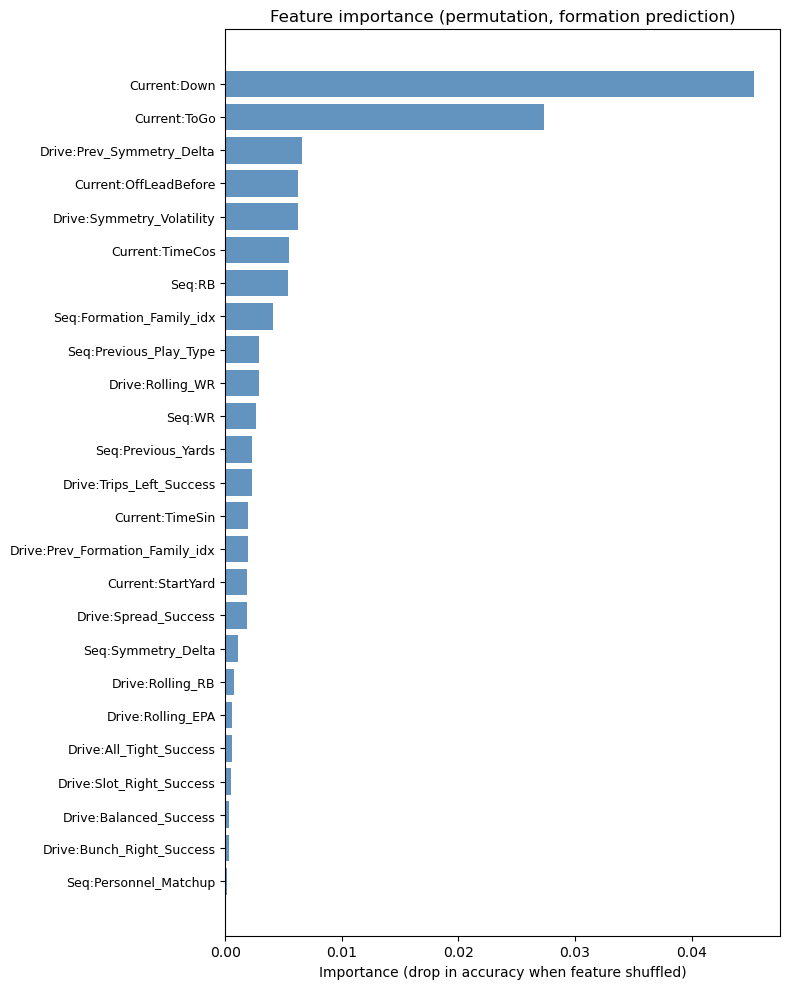

In [14]:
# Feature importance via permutation (drop in formation accuracy when feature is shuffled)
import matplotlib.pyplot as plt

# Collect validation data
model.eval()
seq_list, dc_list, gs_list, off_team_list, y_form_list = [], [], [], [], []
with torch.no_grad():
    for seq, drive_context, current_game_state, off_team_idx, _, y_form in val_loader:
        seq_list.append(seq)
        dc_list.append(drive_context)
        gs_list.append(current_game_state)
        off_team_list.append(off_team_idx)
        y_form_list.append(y_form)
seq_all = torch.cat(seq_list, dim=0).to(DEVICE)
dc_all = torch.cat(dc_list, dim=0).to(DEVICE)
gs_all = torch.cat(gs_list, dim=0).to(DEVICE)
off_team_all = torch.cat(off_team_list, dim=0).to(DEVICE)
y_form_all = torch.cat(y_form_list, dim=0)

def get_formation_accuracy(seq, drive_context, current_game_state, off_team_idx, y_form, batch_size=256):
    model.eval()
    correct, total = 0, seq.size(0)
    with torch.no_grad():
        for i in range(0, total, batch_size):
            end = min(i + batch_size, total)
            p_logits, f_logits = model(seq[i:end], drive_context[i:end], current_game_state[i:end], off_team_idx[i:end])
            correct += (f_logits.argmax(1) == y_form[i:end].to(DEVICE)).sum().item()
    return correct / total

baseline_acc = get_formation_accuracy(seq_all, dc_all, gs_all, off_team_all, y_form_all)
print('Baseline formation accuracy (validation):', round(baseline_acc, 4))

n_seq_feat = seq_all.size(2)
n_dc_feat = dc_all.size(1)
n_gs_feat = gs_all.size(1)
feature_names = [f'Seq:{c}' for c in seq_feat_cols] + [f'Drive:{c}' for c in DRIVE_CONTEXT_FEAT] + [f'Current:{c}' for c in CURRENT_GAME_STATE]
importance = np.zeros(n_seq_feat + n_dc_feat + n_gs_feat)
rng = np.random.default_rng(42)

for j in range(n_seq_feat):
    seq_perm = seq_all.cpu().clone()
    perm_idx = rng.permutation(seq_perm.size(0))
    seq_perm[:, :, j] = seq_perm[perm_idx, :, j]
    seq_perm = seq_perm.to(DEVICE)
    acc = get_formation_accuracy(seq_perm, dc_all, gs_all, off_team_all, y_form_all)
    importance[j] = baseline_acc - acc
for j in range(n_dc_feat):
    dc_perm = dc_all.cpu().clone()
    perm_idx = rng.permutation(dc_perm.size(0))
    dc_perm[:, j] = dc_perm[perm_idx, j]
    dc_perm = dc_perm.to(DEVICE)
    acc = get_formation_accuracy(seq_all, dc_perm, gs_all, off_team_all, y_form_all)
    importance[n_seq_feat + j] = baseline_acc - acc
for j in range(n_gs_feat):
    gs_perm = gs_all.cpu().clone()
    perm_idx = rng.permutation(gs_perm.size(0))
    gs_perm[:, j] = gs_perm[perm_idx, j]
    gs_perm = gs_perm.to(DEVICE)
    acc = get_formation_accuracy(seq_all, dc_all, gs_perm, off_team_all, y_form_all)
    importance[n_seq_feat + n_dc_feat + j] = baseline_acc - acc

# Plot: top features by importance (positive = feature helps; shuffle hurt accuracy)
order = np.argsort(importance)[::-1]
top_k = min(25, len(feature_names))
idx = order[:top_k]
fig, ax = plt.subplots(figsize=(8, 10))
ax.barh(range(top_k), importance[idx], color='steelblue', alpha=0.85)
ax.set_yticks(range(top_k))
ax.set_yticklabels([feature_names[i] for i in idx], fontsize=9)
ax.set_xlabel('Importance (drop in accuracy when feature shuffled)')
ax.set_title('Feature importance (permutation, formation prediction)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

Baseline formation PR-AUC (macro, validation): 0.1425


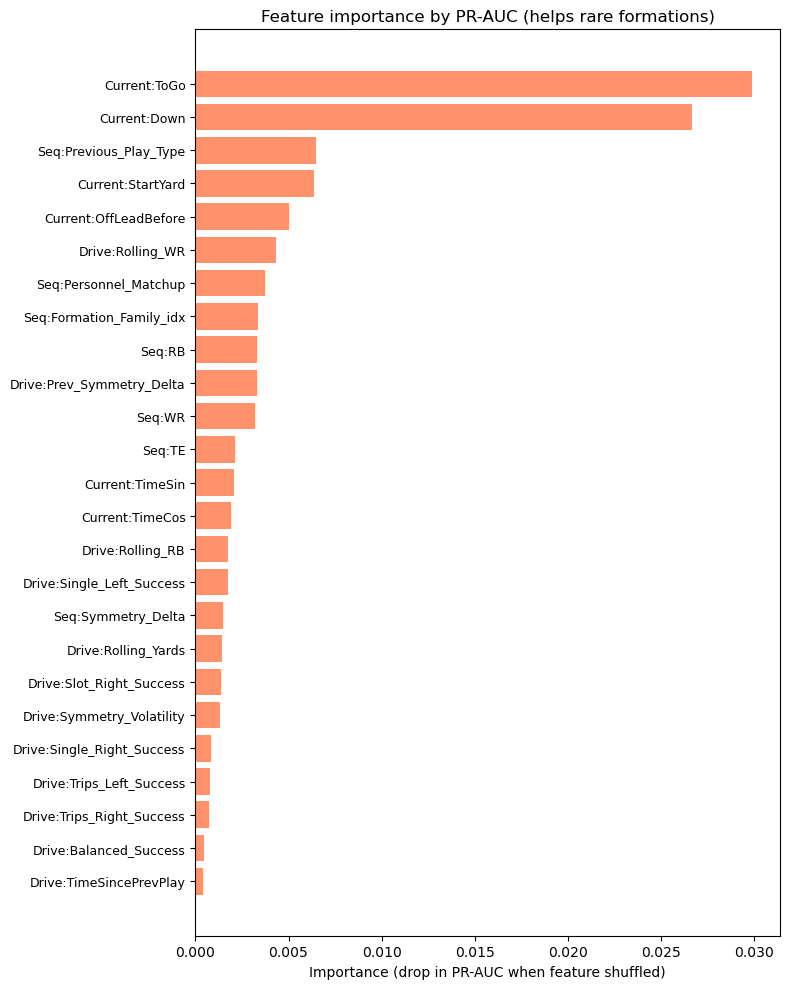

In [15]:
# Optional: Permutation importance using PR-AUC (surfaces features that help rare formations)
from sklearn.metrics import average_precision_score

def get_formation_pr_auc_macro(seq, drive_context, current_game_state, off_team_idx, y_form, n_classes, batch_size=256):
    model.eval()
    probs = []
    with torch.no_grad():
        for i in range(0, seq.size(0), batch_size):
            end = min(i + batch_size, seq.size(0))
            _, f_logits = model(seq[i:end], drive_context[i:end], current_game_state[i:end], off_team_idx[i:end])
            probs.append(torch.softmax(f_logits, dim=1).cpu().numpy())
    y_true = y_form.cpu().numpy()
    proba = np.concatenate(probs, axis=0)
    ap_per_class = [average_precision_score((y_true == c).astype(float), proba[:, c]) for c in range(n_classes)]
    return np.nanmean(ap_per_class)

baseline_pr_auc = get_formation_pr_auc_macro(seq_all, dc_all, gs_all, off_team_all, y_form_all, n_formations)
print('Baseline formation PR-AUC (macro, validation):', round(baseline_pr_auc, 4))

importance_pr = np.zeros(n_seq_feat + n_dc_feat + n_gs_feat)
for j in range(n_seq_feat):
    seq_perm = seq_all.cpu().clone()
    perm_idx = rng.permutation(seq_perm.size(0))
    seq_perm[:, :, j] = seq_perm[perm_idx, :, j]
    seq_perm = seq_perm.to(DEVICE)
    importance_pr[j] = baseline_pr_auc - get_formation_pr_auc_macro(seq_perm, dc_all, gs_all, off_team_all, y_form_all, n_formations)
for j in range(n_dc_feat):
    dc_perm = dc_all.cpu().clone()
    perm_idx = rng.permutation(dc_perm.size(0))
    dc_perm[:, j] = dc_perm[perm_idx, j]
    dc_perm = dc_perm.to(DEVICE)
    importance_pr[n_seq_feat + j] = baseline_pr_auc - get_formation_pr_auc_macro(seq_all, dc_perm, gs_all, off_team_all, y_form_all, n_formations)
for j in range(n_gs_feat):
    gs_perm = gs_all.cpu().clone()
    perm_idx = rng.permutation(gs_perm.size(0))
    gs_perm[:, j] = gs_perm[perm_idx, j]
    gs_perm = gs_perm.to(DEVICE)
    importance_pr[n_seq_feat + n_dc_feat + j] = baseline_pr_auc - get_formation_pr_auc_macro(seq_all, dc_all, gs_perm, off_team_all, y_form_all, n_formations)

order_pr = np.argsort(importance_pr)[::-1]
idx_pr = order_pr[:top_k]
fig, ax = plt.subplots(figsize=(8, 10))
ax.barh(range(top_k), importance_pr[idx_pr], color='coral', alpha=0.85)
ax.set_yticks(range(top_k))
ax.set_yticklabels([feature_names[i] for i in idx_pr], fontsize=9)
ax.set_xlabel('Importance (drop in PR-AUC when feature shuffled)')
ax.set_title('Feature importance by PR-AUC (helps rare formations)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [16]:
# Merge prediction probabilities back to the original dataframe (all plays with enough drive history)
full_ds = PlaySequenceDataset(rows)
full_loader = DataLoader(full_ds, batch_size=256, shuffle=False)
pass_proba_all, formation_proba_all = predict_proba(full_loader, model, DEVICE)

probs_df = pd.DataFrame({
    'df_index': [r['df_index'] for r in rows],
    'P_pass': pass_proba_all,
    'predicted_pass_run': np.where(pass_proba_all >= 0.5, 'pass', 'rush')
})
for k, form_name in enumerate(FORMATION_LIST):
    probs_df[f'P_{form_name}'] = formation_proba_all[:, k]
probs_df['predicted_formation'] = [FORMATION_LIST[i] for i in formation_proba_all.argmax(axis=1)]

# Left join: original df gets probability columns; plays without enough history keep NaN
df = df.merge(probs_df, left_index=True, right_on='df_index', how='left')
df = df.drop(columns=['df_index'], errors='ignore')

print('Original dataframe now has probability columns. Rows with predictions:', df['P_pass'].notna().sum())
df

Original dataframe now has probability columns. Rows with predictions: 32766


,Season,Wk,HomeTeam,AwayTeam,QTR,TimeLeftQTR,OffTeam,DefTeam,OffLeadBefore,FieldSide,StartYard,Down,ToGo,EventType,RB,WR,TE,OL,DL,LB,DB,Safeties,CoverageType,ReceiverAlignment,Dropback,DropType,Scramble,RPO,Attempt,Completion,Sacked,LWR,LSWR,LTE,RWR,RSWR,RTE,L1,L2,L3,L4,R4,R3,R2,R1,TargetedPlayer,YardsOnPlay,EPA,_game_play_seq,_drive_id,TimeLeftGame,is_pass,formation_clean,formation_idx,TimeSin,TimeCos,personnel_idx,Personnel_Matchup,Previous_Play_Type,Previous_Yards,Previous_EPA,Rolling_RB,Rolling_WR,Rolling_TE,Rolling_EPA,Rolling_Yards,TimeSincePrevPlay,Prev_CoverageType,Prev_CoverageType_idx,off_team_idx,Align_L1,Align_L2,Align_L3,Align_L4,Align_R4,Align_R3,Align_R2,Align_R1,Right_Side_Count,Max_Right_Width,Right_Spread_Index,Is_TE_Opposite,Personnel_x_StrengthCount,Total_Left_Count,Total_Right_Count,Symmetry_Delta,Formation_Family,Formation_Family_idx,Prev_Symmetry_Delta,Prev_Formation_Family_idx,Symmetry_Volatility,Spread_Rate,Balanced_Success,Slot_Left_Success,Twin_Right_Success,Twin_Left_Success,Trips_Right_Success,Slot_Right_Success,Trips_Left_Success,Single_Left_Success,Single_Right_Success,Spread_Success,Bunch_Right_Success,Bunch_Left_Success,All_Tight_Success,Goal_Line_Success,Prev_Right_Side_Count,Prev_Max_Right_Width,Prev_Right_Spread_Index,Prev_Is_TE_Opposite,Prev_Personnel_x_StrengthCount,Rolling_3_Right_Side_Count,Rolling_3_Max_Right_Width,Rolling_3_Right_Spread_Index,Rolling_3_Is_TE_Opposite,Rolling_3_Personnel_x_StrengthCount,P_pass,predicted_pass_run,P_Balanced,P_Slot Left,P_Twin Right,P_Twin Left,P_Trips Right,P_Slot Right,P_Trips Left,P_Single Left,P_Single Right,P_Spread,P_Bunch Right,P_Bunch Left,P_All Tight,P_Goal Line,predicted_formation
0.0,2025,1,ATL,TB,1,894,ATL,TB,0,Own,35,1,10,pass,2,2,1,5,3.0,4.0,4,2,Cover 2,Spread,1.0,0/1 Step,0,0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,Hook,Cross,Out,NaN,NaN,NaN,Shallow,Cross,R1,11,0.529828,0,1,3594,1,Spread,9.0,-0.010472,0.999945,28,-2.0,0.5,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,Unknown,14,1,-0.25,-0.5,-0.75,0.0,0.0,0.00,0.5,0.25,4.0,2.0,1.0,0.0,0.0,6.0,4.0,2.0,Bunch_Stack,2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.428505,rush,0.152274,0.131139,0.113050,0.095178,0.078544,0.094963,0.077216,0.103377,0.083756,0.020701,0.022623,0.019183,0.007129,0.000866,Balanced
1.0,2025,1,ATL,TB,1,850,ATL,TB,0,Own,46,1,10,rush,1,2,2,5,3.0,4.0,4,1,NaN,Slot Left,NaN,NaN,0,0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,-0.235060,1,1,3550,0,Slot Left,1.0,-0.087156,0.996195,15,-2.0,1.0,11.0,0.529828,2.0,2.000000,1.000000,0.529828,11.000000,44.0,Cover 2,3,1,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,2.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,Condensed_Nasty,1,2.0,2.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,2.0,1.0,0.0,0.0,4.000000,2.000000,1.0,0.0,0.0,0.326527,rush,0.173152,0.126176,0.120987,0.116017,0.053051,0.088622,0.055594,0.128661,0.092983,0.015549,0.011662,0.010539,0.005641,0.001366,Balanced
2.0,2025,1,ATL,TB,1,806,ATL,TB,0,Own,50,2,6,pass,1,2,2,5,3.0,4.0,4,1,Cover 6,Twin Right,1.0,5 Step,0,0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,Cross,NaN,NaN,NaN,NaN,NaN,Post,Corner,Back,50,3.796560,2,1,3506,1,Twin Right,2.0,-0.163326,0.986572,15,-2.0,0.0,4.0,-0.235060,1.5,2.000000,1.500000,0.147384,7.500000,44.0,Unknown,14,1,-0.25,0.0,0.00,0.0,0.0,0.00,0.5,0.25,4.0,2.0,1.0,1.0,0.0,3.0,4.0,-1.0,Condensed_Nasty,1,0.0,1.0,1.414214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.000000,1.000000,0.5,0.0,0.0,0.653065,pass,0.155513,0.094435,0.097103,0.087852,0.147819,0.072213,0.128289,0.059996,0.034075,0.042056,0.037832,0.034720,0.006695,0.001402,Balanced
3.0,2025,1,ATL,TB,1,794,TB,ATL,-7,Own,40,1,10,pass,1,2,2,5,4.0,2.0,5,1,Cover 1,Balanced,1.0,3 Step,0,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,Cross,NaN,NaN,NaN,NaN,NaN,Flat,Corner,NaN,0,-0.687909,3,2,3494,1,Balanced,0.0,-0.183951,0.982935,15,-3.0,0.5,0.0,0.000000,0.0,0.000000,

In [17]:
print(df['predicted_formation'].value_counts())
print(df['predicted_pass_run'].value_counts())

predicted_formation
Balanced        14448
Trips Right      5509
Slot Left        3810
Trips Left       2724
Single Left      2516
Twin Right       1374
Twin Left        1187
Single Right      594
Slot Right        408
Goal Line          88
All Tight          61
Spread             47
Name: count, dtype: int64
predicted_pass_run
pass    20076
rush    12690
Name: count, dtype: int64


In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('predictability_scores.csv')

In [11]:
data.sort_values(by = 'Relative_Predictability', ascending = False).head(50)

,Unnamed: 0,Season,Wk,HomeTeam,AwayTeam,_drive_id,_game_play_seq,Down,ToGo,StartYard,OffTeam,ReceiverAlignment,Rolling_EPA,Rolling_Yards,TimeSincePrevPlay,Prev_Symmetry_Delta,Spread_Rate,P_score,Entropy,Relative_Predictability,Actual_Formation,Predicted_Formation
17750,18056,2025,10,TB,NE,10,56,2,1,1,NE,Goal Line,0.680989,4.666667,41.0,-1.0,0.0,0.522633,1.743317,0.384903,Goal Line,Goal Line
13299,13534,2025,8,CAR,BUF,14,73,2,2,20,BUF,Single Left,0.417744,8.000000,41.0,-2.0,0.0,0.436276,1.814563,0.311140,Single Left,Single Left
31094,31629,2025,18,BUF,NYJ,15,94,2,4,12,BUF,Single Left,0.813088,14.333333,42.0,-2.0,0.0,0.436305,1.725011,0.302680,Single Left,Single Left
31095,31630,2025,18,BUF,NYJ,15,95,1,6,6,BUF,Single Left,0.583574,8.666667,43.0,-2.0,0.0,0.424244,1.758677,0.293462,Single Left,Single Left
14624,14876,2025,9,BUF,KC,17,98,2,4,37,BUF,Single Left,0.831594,6.000000,42.0,-4.0,0.0,0.419180,1.836393,0.285556,Single Left,Single Left
22895,23283,2025,13,PIT,BUF,13,77,2,3,24,BUF,Single Left,0.433939,7.000000,41.0,-1.0,0.0,0.421814,1.855143,0.284826,Single Left,Single Left
27521,27994,2025,16,CLE,BUF,2,9,2,3,27,BUF,Single Left,0.685744,7.000000,39.0,-4.0,0.0,0.421408,1.808039,0.284420,Single Left,Single Left
31068,31603,2025,18,BUF,NYJ,11,68,2,1,31,BUF,Single Left,0.908177,11.500000,44.0,-4.0,0.0,0.416276,1.792550,0.278546,Single Left,Single Left
3986,4055,2025,3,BUF,MIA,4,21,2,1,46,BUF,Single Left,0.638618,9.000000,40.0,-1.0,0.0,0.402414,1.867252,0.264684,Single Left,Single Left
22887,23275,2025,13,PIT,BUF,11,69,1,7,7,BUF,Single Left,1.111550,15.333333,29.0,-2.0,0.0,0.394755,1.921165,0.263113,Single Left,Single Left
